<a href="https://colab.research.google.com/github/aryan16x/generative_deep_learning/blob/main/standard_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utils

In [1]:
import matplotlib.pyplot as plt

def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()

def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

import numpy as np
import matplotlib.pyplot as plt

def get_vector_from_label(data, vae, embedding_dim, label):
    current_sum_POS = np.zeros(shape=embedding_dim, dtype="float32")
    current_n_POS = 0
    current_mean_POS = np.zeros(shape=embedding_dim, dtype="float32")

    current_sum_NEG = np.zeros(shape=embedding_dim, dtype="float32")
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape=embedding_dim, dtype="float32")

    current_vector = np.zeros(shape=embedding_dim, dtype="float32")
    current_dist = 0

    print("label: " + label)
    print("images : POS move : NEG move :distance : 𝛥 distance")
    while current_n_POS < 10000:
        batch = list(data.take(1).get_single_element())
        im = batch[0]
        attribute = batch[1]

        _, _, z = vae.encoder.predict(np.array(im), verbose=0)

        z_POS = z[attribute == 1]
        z_NEG = z[attribute == -1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis=0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS - current_mean_POS)

        if len(z_NEG) > 0:
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis=0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG - current_mean_NEG)

        current_vector = new_mean_POS - new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist

        print(
            str(current_n_POS)
            + "    : "
            + str(np.round(movement_POS, 3))
            + "    : "
            + str(np.round(movement_NEG, 3))
            + "    : "
            + str(np.round(new_dist, 3))
            + "    : "
            + str(np.round(dist_change, 3))
        )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print("Found the " + label + " vector")
            break

    return current_vector


def add_vector_to_images(data, vae, feature_vec):
    n_to_show = 5
    factors = [-4, -3, -2, -1, 0, 1, 2, 3, 4]

    example_batch = list(data.take(1).get_single_element())
    example_images = example_batch[0]

    _, _, z_points = vae.encoder.predict(example_images, verbose=0)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):
        img = example_images[i]
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis("off")
        sub.imshow(img)

        counter += 1

        for factor in factors:
            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = vae.decoder.predict(
                np.array([changed_z_point]), verbose=0
            )[0]

            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis("off")
            sub.imshow(changed_image)

            counter += 1

    plt.show()


def morph_faces(data, vae):
    factors = np.arange(0, 1, 0.1)

    example_batch = list(data.take(1).get_single_element())[:2]
    example_images = example_batch[0]
    _, _, z_points = vae.encoder.predict(example_images, verbose=0)

    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0]
    sub = fig.add_subplot(1, len(factors) + 2, counter)
    sub.axis("off")
    sub.imshow(img)

    counter += 1

    for factor in factors:
        changed_z_point = z_points[0] * (1 - factor) + z_points[1] * factor
        changed_image = vae.decoder.predict(
            np.array([changed_z_point]), verbose=0
        )[0]
        sub = fig.add_subplot(1, len(factors) + 2, counter)
        sub.axis("off")
        sub.imshow(changed_image)

        counter += 1

    img = example_images[1]
    sub = fig.add_subplot(1, len(factors) + 2, counter)
    sub.axis("off")
    sub.imshow(img)

    plt.show()

# Standard Autoencoders

In [2]:
from tensorflow.keras import datasets,backend,metrics,losses,layers,models
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
(x_train,y_train), (x_test,y_test) = datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
def preprocess(imgs):
  imgs = imgs.astype("float32")/255.0
  imgs = np.pad(imgs, ((0,0),(2,2),(2,2)), constant_values=0.0)
  imgs = np.expand_dims(imgs, -1)
  return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

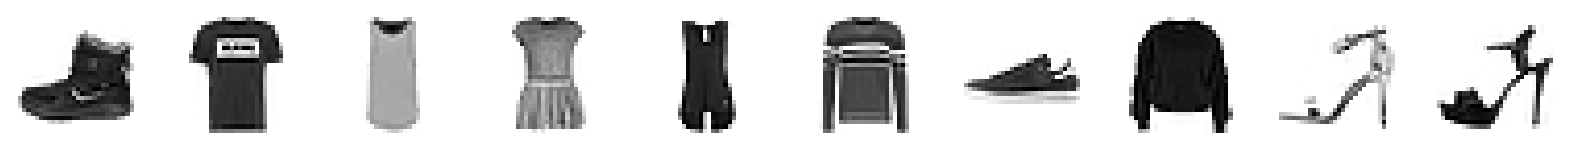

In [5]:
display(x_train)

In [6]:
# Encoder

encoder_input = layers.Input(shape=(32,32,1), name="encoder_input")
x = layers.Conv2D(32, (3,3), strides=2, activation="relu", padding="same")(encoder_input)
x = layers.Conv2D(64, (3,3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3,3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = backend.int_shape(x)[1:]

x = layers.Flatten()(x)
encoder_output = layers.Dense(2, name="encoder_output")(x)
encoder = models.Model(encoder_input,encoder_output)
encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 16, 16, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_output (Dense)               │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Decoder

decoder_input = layers.Input(shape=(2,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3,3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3,3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3,3), strides=2, activation="relu", padding="same")(x)

decoder_output = layers.Conv2D(
    1,
    (3,3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output"
)(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2D)              │ (None, 32, 32, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
autoencoder = models.Model(encoder_input, decoder(encoder_output))
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [9]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=3,
    batch_size=100,
    shuffle=True,
    validation_data=(x_test,x_test)
)

Epoch 1/3
600/600 ━━━━━━━━━━━━━━━━━━━━ 228s 376ms/step - loss: 0.3571 - val_loss: 0.2649
Epoch 2/3
600/600 ━━━━━━━━━━━━━━━━━━━━ 253s 360ms/step - loss: 0.2608 - val_loss: 0.2590
Epoch 3/3
600/600 ━━━━━━━━━━━━━━━━━━━━ 258s 354ms/step - loss: 0.2563 - val_loss: 0.2563


In [10]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step
Example real clothing items


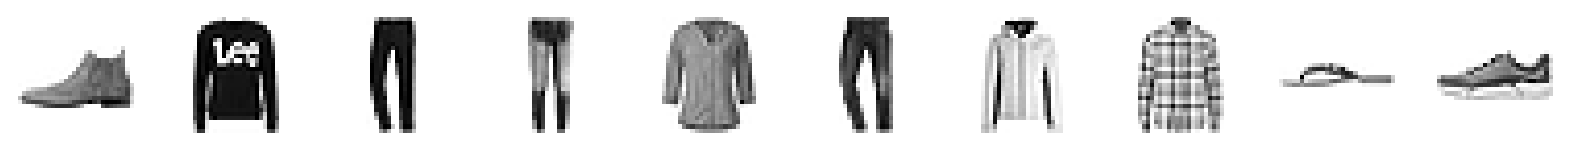

Reconstructions


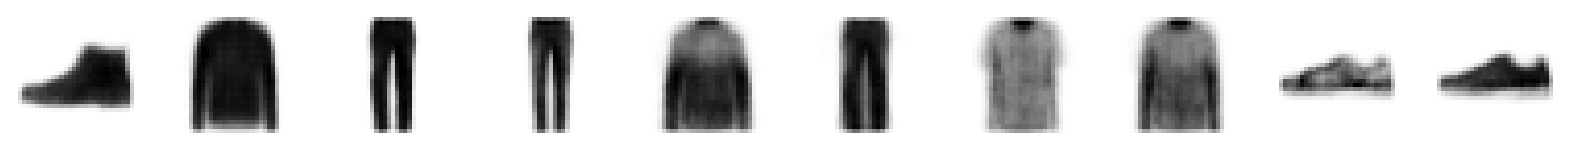

In [11]:
predictions = autoencoder.predict(example_images)

print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(predictions)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


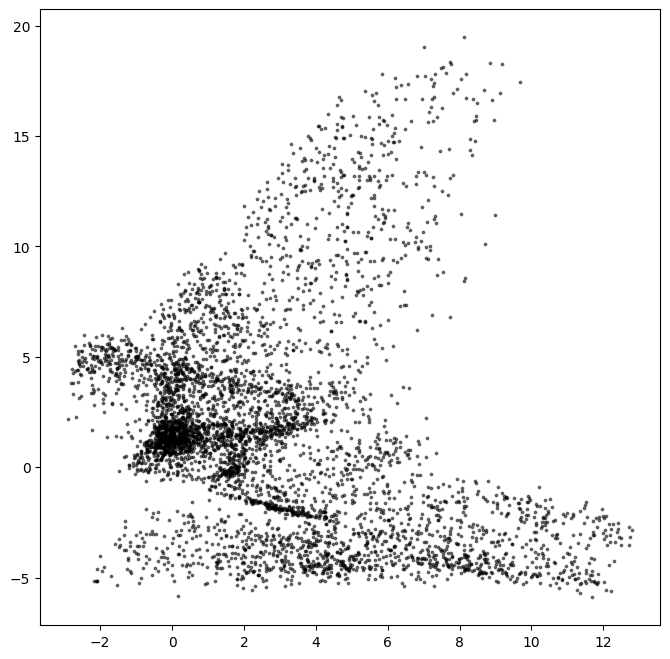

In [12]:
# Visualizing the latent space

embeddings = encoder.predict(example_images)

plt.figure(figsize=(8,8))
plt.scatter(embeddings[:,0], embeddings[:,1], c="black", alpha=0.5, s=3)
plt.show()

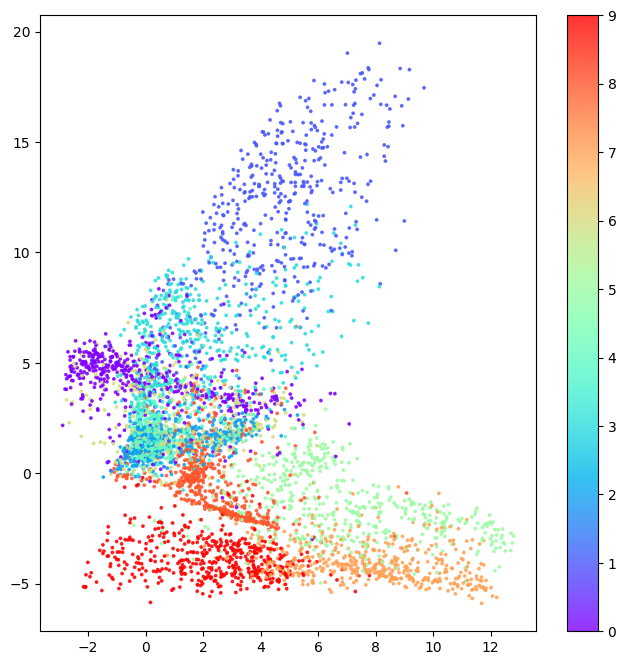

In [13]:
# Colour the embeddings by their label (clothing type - see table)
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()